# Deep learning technical model for ETFs

* Kibot etf data 
* Based of `etf_deep_learning_2020.04.27`
* In the old notebook, I was having a lot of trouble gettign good minibatch training (because the effective sample size varies a lot from minibatch to minibatch)
* Modified this to use a Hankelized dataset containing only valid data (no nulls)

#### NOTE : This will require rethinking the "timing" component of the factor model to use a look up tensor (like in cadre/avm work)

In [1]:
# preamble
%alias_magic  nbagg matplotlib -p nbagg
%alias_magic  inline matplotlib -p inline
%load_ext memory_profiler

from io import BytesIO
from IPython.display import display, Image, HTML
from pylab import *
plt.style.use( 'seaborn-whitegrid' )

from madmax.api import *
mx = mx.reload()
mxtr = mxtr.reload()

from research import yahoo; reload( yahoo)

###################################################################
# Interactive configuration 
# When running a config grid this will throw a FrozenException 
# and the grid Config will be used
###################################################################
try:
    mx.Config.name = 'etf_technical/deep_learning/2020.04.30'
    mx.Config.mode = 'interactive'
    mx.Config.hps = mx.HPSet()
    mx.Config.code = 'etf_deep_learning_2020.04.30  (hankelized training).ipynb'
    disp( 'Running template configuration ', h=2 )        
except mx.Config.FrozenException:
    if mx.Config.mode != 'grid':
        raise RuntimeError( 'An unexpected configruation encountered' )
    disp( 'Running a grid configuration ', h=2 )


hps = mx.Config.hps

device = 'cuda'
dtype = tr.float32

mx.Config.start()


Created `%nbagg` as an alias for `%matplotlib nbagg`.
Created `%inline` as an alias for `%matplotlib inline`.


<IPython.core.display.Javascript object>

<h1> Config etf_technical/deep_learning/2020.04.30 </h1>
<b> hash</b>: none </h4>
<b> mode </b>: interactive
<b> frozen </b>: False
<b> uri </b>: /home/fj/experiments/etf_technical/deep_learning/2020.04.30/none
<h3> Hyperparameters </h3>
HPSet(
	)<h3> Code </h3>
<b> format </b>: .ipynb
<b> code </b> : /local/cloud/code/research/etf_technical/etf_deep_learning_2020.04.30  (hankelized training).ipynb

In [2]:
# --- build data ---
######################################################################################################
from research.etf_technical import load_data as eld; reload( eld )


price_features = ['open_30min', 'high_30min', 'low_30min', 'close_30min', 
                  'open_day', 'high_day', 'low_day', 'close_day', 'close_prev_day', 
                  'open_week', 'high_week', 'low_week', 'close_week', 'close_prev_week', 
                  'open_month', 'high_month', 'low_month', 'close_month', ]
                      
volume_features = ['volume_30min', 'volume_intraday', 'volume_intraweek', 'volume_1hr', 'volume_1day', 
                       'dollar_volume_30min', 'dollar_volume_intraday',
                       'dollar_volume_intraweek', 'dollar_volume_1hr', 'dollar_volume_1day',]
                       
calendar_features = [ 'week', 'month', 'timeofday', 'dayofweek', 'dayofmonth', 
                          'weekofyear', 'cos_timeofday', 'sin_timeofday', 
                          'cos_dayofweek', 'sin_dayofweek', 'cos_dayofmonth',
                          'sin_dayofmonth', 'cos_weekofyear', 'sin_weekofyear',]

returns_features = ['logrtn_lag_intraday', 'logrtn_lag_overnight', 'logrtn_lag_intraweek',
                    'logrtn_lag_weekend', 'logrtn_lag_intramonth', 'logrtn_lag_30min',
                    'logrtn_lag_1hr','logrtn_lag_1day', ]

responses = ['logrtn_lead_30min',  'logrtn_lead_1hr', 'logrtn_lead_1day'] #'logrtn_lead_intraday', 


################################################################################################
# build features for the deep learning (same as teh code for the 30-min online model)
################################################################################################
@mx.operatorize( memoize='md', consumes_features=False, produces_meta=True )
def FeatureBuilder( data, responses=responses,  emv=True, ema=True, equalize_lagging_returns=False,
                    haar=False, dilation=2, levels=5, winsorize=0.05, smz=False,
                    volume_features=volume_features, returns_features=returns_features,
                    verbose=False ):
    '''
    build up the 30 min dataset for learning
    
    equalize_lagging_returns:
        divide out annual vol from all lagging returns features
        Leading returns features are equalized anyways
    '''
    INTS_PER_DAY = 13
    logger = mx.Logger( 'build_features', verbose=verbose )
    das = []
    with logger.timer( 'loading the data'):
        for symbol in logger.pbar( eld.kibot_day_files.keys() ):
            if symbol.startswith( 'INCOMPLETE' ):
                logger.warn( f'No data for {symbol} - SKIPPING' )
                continue
            logger.info( 'loading data for ', symbol )
            da, meta = eld.get_saved_30min_data( symbol=symbol )
            # add a mask to indicate when this feature was valid
            da = da.assign_features( valid=da.loc[:,:,'open_30min'].isfinite() )
            das.append( da )
        da = xa.concat( das, dim='symbol' )
    features = volume_features + returns_features
    with logger.timer( ' compute log features' ):
        for ft in ['dollar_volume_30min', 'open_30min', 'dollar_volume_intraday',  'dollar_volume_intraweek',] :
            da = da.assign_features( **{ f'log_{ft}': da.loc[:,:, ft].log() } )
            features.append( f'log_{ft}' )
    with logger.timer(' compute an annual returns volatility'):
        avc = mx.transforms.rolling( windows='252D', sid='symbol', min_periods=INTS_PER_DAY*60 ).sd()
        da = avc( da, features='logrtn_lag_30min' )
        annual_vol = avc.output_features[0]
        # equalize the response variable
        equalized_responses = []
        for response in responses:
            equalized_response = f'{response}_equalized'
            da = da.assign_features( **{equalized_response: da.loc[:,:,response] / ( da.loc[:,:,annual_vol] + 1e-12 ) } )
            equalized_responses.append( equalized_response )
    if equalize_lagging_returns:
        # equalize all the laggign returns columns inplace ....
        with logger.timer( 'compute "normalized" leading and lagging returns' ):
            da.loc[:,:,returns_features] =  da.loc[:,:,returns_features] / ( da.loc[:,:,annual_vol] + 1e-12 )
            # volume, price and returns vol
    if emv:
        with logger.timer( 'compute volatility' ):
            emv = mx.transforms.exponential( halflifes=np.array( [2, 10, 30] ) * INTS_PER_DAY, sid='symbol' ).sd()
            da = emv( da, features=['log_open_30min', 'log_dollar_volume_30min', 'logrtn_lag_30min', 'logrtn_lag_1day'] )
            features += emv.output_features
    # volume, price and returns sma
    if ema:
        with logger.timer( 'compute ema' ):
            ema = mx.transforms.exponential( halflifes=np.array( [2, 10, 30] ) * INTS_PER_DAY, sid='symbol' ).mean()
            da = ema( da, features=['log_open_30min', 'log_dollar_volume_30min', 'logrtn_lag_30min', 'logrtn_lag_1day'] )
            features += ema.output_features
            # compute haar transform
    if haar:
        with logger.timer( 'compute haar' ):
            haar = mx.transforms.haar( levels=levels, dilation=dilation, sid='symbol' )
            haar.features = ['log_open_30min', 'log_dollar_volume_30min', 'logrtn_lag_30min', 'logrtn_lag_1day']
            da = haar( da )
            features += haar.output_features
    # winsorize the features we've constructed and other good stuff
    if winsorize:
        with logger.timer( 'winsorizing' ):
            wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=winsorize )
            wins.features = sorted( set(features + [annual_vol] + equalized_responses  ) )
            da = wins( da )
            # drop the original features and rename the winsorized one
            da = (da.drop_coords( features=wins.features )
                  .rename_coords( features=dict( zip( wins.output_features, wins.features ) ) ))
    # zscore the features
    if smz:
        with logger.timer( 'zscoring' ):
            zscore = mx.transforms.rolling( windows=smz, sid='symbol' ).zscore()
            da = zscore( da, features=features )
            # drop the original features and rename the zscored one
            da = da.drop_coords( features=zscore.features ).rename_coords( features=dict( zip( zscore.output_features, zscore.features ) ) )
    # add a dummy weight column
    da = da.assign_features( one=1 )
    return da, features, dict( equalized_responses=equalized_responses, annual_vol=annual_vol )


builder = FeatureBuilder( responses=responses, volume_features=volume_features, returns_features=returns_features, smz=False  )
builder.data = None

da = builder()
disp( 'expected FeatureBuilder_8f67a6e37 got', builder.hash() )

# obtain the metadata for each symbol
metas = []
for symbol in da.symbol.values:
    for etf_list in [eld.bond_etfs, eld.equity_etfs, eld.vol_etfs]:
        if symbol in etf_list.Symbol.values:
            metas.append( etf_list[etf_list.Symbol == symbol].iloc[0].to_dict() )
            break

da = da.loc['20050101':]            
meta_df =pd.DataFrame(metas)     
hps = mx.HPSet()

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


## Setup the training, validation and testing datasets


In [3]:
#setup the datasets
#--------------------------------
%nbagg
mxtr = mxtr.reload() 

hps.winlen = 13 * 3 * (2 ** 5) + 512  # window lenght for haneklization (atleast more than 4 dilation levels)
hps.standardize_features = True
hps.responses = [ 'logrtn_lead_1day_equalized'] #['logrtn_lead_30min_equalized', 'logrtn_lead_1hr_equalized', 'logrtn_lead_1day_equalized'] #
hps.features =([ 
    'logrtn_lag_overnight', 'logrtn_lag_weekend', 'logrtn_lag_30min', 'logrtn_lag_1hr', 'logrtn_lag_1day',
    'logrtn_lag_intraday', 'logrtn_lag_intraweek',    'logrtn_lag_intramonth',
    'logrtn_lag_30min_26.ew_sd',  'logrtn_lag_1day_26.ew_sd',  'logrtn_lag_30min_130.ew_sd', 'logrtn_lag_1day_130.ew_sd',
    'logrtn_lag_30min_390.ew_sd', 'logrtn_lag_1day_390.ew_sd','logrtn_lag_30min_26.ew_mean', 'logrtn_lag_1day_26.ew_mean',
    'logrtn_lag_30min_130.ew_mean', 'logrtn_lag_1day_130.ew_mean','logrtn_lag_30min_390.ew_mean', 'logrtn_lag_1day_390.ew_mean',
    'log_dollar_volume_30min', 'log_dollar_volume_intraday', 'log_dollar_volume_intraweek',
    'log_dollar_volume_30min_26.ew_sd',  'log_dollar_volume_30min_130.ew_sd', 'log_dollar_volume_30min_390.ew_sd', 
    'log_dollar_volume_30min_26.ew_mean',  'log_dollar_volume_30min_130.ew_mean', 'log_dollar_volume_30min_390.ew_mean', 
    'log_open_30min', 'log_open_30min_26.ew_sd',  'log_open_30min_130.ew_sd',  'log_open_30min_390.ew_sd', 'log_open_30min_26.ew_mean', 
    'log_open_30min_130.ew_mean', 'log_open_30min_390.ew_mean', 
]) 
hps.calendar_features = ['cos_timeofday', 'sin_timeofday', 'cos_dayofweek', 'sin_dayofweek', 'cos_dayofmonth','sin_dayofmonth', 'cos_weekofyear', 'sin_weekofyear']

# convert time and sid to integers for use in pytorch
class coord_maps:
    int_to_time = pd.Series( da.time.values, index=np.arange( len( da.time ) ) )
    time_to_int = pd.Series( np.arange( len( da.time ) ),  index=da.time.values )
    int_to_sid = pd.Series( da.symbol.values, index=np.arange( len( da.symbol ) ) )
    sid_to_int = pd.Series( np.arange( len( da.symbol ) ),  index=da.symbol.values )
    
da_int = da.rename_coords( time=coord_maps.time_to_int, symbol=coord_maps.sid_to_int )
X_da = da_int.loc[:,:,hps.features + hps.calendar_features]
Y_da = da_int.loc[:,:,hps.responses]
# compute the valid-data-mask - and account for per-instrument priming in it
V_da = (da_int.loc[:,:,'valid']
        # fill small gaps
        .ffill( dim='time', limit=13*10 ) 
        # keep only the valid data for each symbol
        .notnull() ) 
V_da = ( V_da * da_int.loc[:,:,'valid'].fillna(0) )
# the weight matrix --- to do.
W_da = da_int.loc[:,:,'valid'].broadcast_like( Y_da ) 

# split the data into trg, val and testing 
hps.trg_mask = arange( 0, len( da ) // 2 )
# note adjustment for model priming
hps.val_mask = arange( hps.trg_mask.max(), int( len( da ) * 0.75 ) )
hps.tst_mask = arange( hps.val_mask.max(), len( da ) )
hps.trg_dates = pd.to_datetime( (da[hps.trg_mask].time.min().values, da[hps.trg_mask].time.max().values) )
hps.val_dates = pd.to_datetime( (da[hps.val_mask].time.min().values, da[hps.val_mask].time.max().values) )
hps.tst_dates = pd.to_datetime( (da[hps.tst_mask].time.min().values, da[hps.tst_mask].time.max().values) )


print( f'trg_fraction=', len(hps.trg_mask)/len(da), f'val_fraction=', len(hps.val_mask)/len(da), f'tst_fraction=', len(hps.tst_mask)/len(da) )

# standardize the features using the training data (non-nulls only)
if hps.standardize_features:
    X_da = (X_da - X_da[hps.trg_mask].mean( dim=['time', 'symbol'] ))  / ( X_da[hps.trg_mask].std( dim=['time', 'symbol'] ) + 1e-12)
    Y_da = (Y_da - Y_da[hps.trg_mask].mean( dim=['time', 'symbol'] ))  / ( Y_da[hps.trg_mask].std( dim=['time', 'symbol'] ) + 1e-12)
    
disp( 'X mean', X_da.mean( dim=['time', 'symbol'] ), 'std', X_da.std( dim=['time', 'symbol'] ) )
disp( 'Y mean', Y_da.mean( dim=['time', 'symbol'] ), 'std', Y_da.std( dim=['time', 'symbol'] ) )
    
# nan-fill for later processing
X_da = X_da.fillna(0)
Y_da = Y_da.fillna(0)
W_da = W_da.fillna(0)

    
# -- build the dataset objects -----
with mx.timer( 'hankeling trg'):
    trg_hankel_dataset = mxtr.HankelDataset(  
        X_da[hps.trg_mask].fillna(0), Y_da[hps.trg_mask].fillna(0), W_da[hps.trg_mask].fillna(0), 
        valid_da=V_da[hps.trg_mask], winlen=hps.winlen, min_periods=hps.winlen,
        dtype=dtype,
    )
with mx.timer( 'hankeling val'):
    val_hankel_dataset = mxtr.HankelDataset(  
        X_da[hps.val_mask].fillna(0), Y_da[hps.val_mask].fillna(0), W_da[hps.val_mask].fillna(0), 
        valid_da=V_da[hps.val_mask], winlen=hps.winlen, min_periods=hps.winlen,
        dtype=dtype,
    )    
if False:
    with mx.timer(' test the hankelization ----'):
        for self, mask in ( (trg_hankel_dataset, hps.trg_mask), (val_hankel_dataset, hps.val_mask) ):
            self.test_hankelization( X_da[mask].fillna(0), da_ix=0 )
            self.test_hankelization( Y_da[mask].fillna(0), da_ix=1 )

full_panel_dataset = mxtr.TensorDataset(
    V_da.time.broadcast_like(V_da).to_tensor( dtype=tr.int32 ),
    V_da.symbol.broadcast_like(V_da).to_tensor( dtype=tr.int32 ),
    X_da.fillna(0).to_tensor( dtype=dtype ),     
    Y_da.fillna(0).to_tensor( dtype=dtype ),  
    W_da.fillna(0).to_tensor( dtype=dtype ),  
)

tst_panel_dataset  = mxtr.TensorDataset( *full_panel_dataset[hps.tst_mask] )

trg_fraction= 0.5 val_fraction= 0.25002025439520376 tst_fraction= 0.25002025439520376


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## The model 

In [25]:
# -- setup the model --
mxtr = mxtr.reload()
from research.etf_technical import model_v1 as mdl; reload(mdl)
mx.Config.start()

disp( mx.tensorboard.start( clear=True ) )
disp( mx.tensorboard.start_server() )

hps.loss_hps = mx.HPSet(
    kapow = 1e-8,
    curvature = None,
    dirichlet = None,
    lasso = None,
    lipschitz = 1e-1,
    logdet = None,
    neumann = None,
    ridge = 1e-3,
    smooth_lasso = None,
    tv = 1e-6,
    priming=13 * 3 * (2 ** 5),
    patience=1, # for logging
    error='mse',
)
mx.seed( 17 )
model = mdl.FactorResnet(     
    num_features = len( hps.features + hps.calendar_features ),
    num_responses = len( hps.responses ),
    hydra=False,
    activation = 'leaky_relu',
    batch_norm=True,
    L = 13 * 15,  # 3 day convolution kernel
    resnet_layers = 1,
    resnet_gating = False,
    resnet_channels = 10,
    dilation=2,
    monitor=True,
    loss_hps=hps.loss_hps,
).initialize( 'normal' ).to( dtype ).to( device )

desc = model.describe()
desc = desc[desc['type'] != 'Identity']
disp( desc , size=5 )

,name,type,shape,numel,norm,dtype,device,arguments
0,,FactorResnet,,20011,13.636254,,,"{'num_features': 44, 'num_responses': 1, 'acti..."
1,first_layer/,OneLayer,,470,6.324555,,,"{'name': 'first', 'L': None, 'Pin': 44, 'Pout'..."
2,first_layer/convolution/,Linear,,450,3.162278,,,"{'in_features': 44, 'out_features': 10, 'bias'..."
3,first_layer/convolution/weight,Parameter,"(10, 44)",440,3.162278,torch.float32,cuda:0,
4,first_layer/convolution/bias,Parameter,"(10,)",10,0.000000,torch.float32,cuda:0,
5,first_layer/batch_norm/,BatchNormPanel,,20,3.162278,,,"{'num_features': 10, 'eps': 1e-05, 'momentum':..."
6,first_layer/batch_norm/weight,Parameter,"(10,)",10,3.162278,torch.float32,cuda:0,
7,first_layer/batch_norm/bias,Parameter,"(10,)",10,0.000000,torch.float32,cuda:0,
8,first_layer/activation/,LeakyReLU,,0,0.000000,,,"{'negative_slope': 0.1, 'inplace': False}"
9,first_layer/monitor/,FlowMonitor,,0,0.000000,,,"{'name': 'FlowMonitor/first', 'patience': 15}"


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_20,DK_30,DK_40,DK_50,DK_60,DK_70,DK_80,DK_90,ac_1,ac_13,ac_26
sample,,,,,,,,,,,,,,,,,,,
trg,4863142,0.717897,-0.097662,0.449702,0.014505,0.000210,25.530121,1.685968,1.471353,1.412265,1.396373,1.398647,1.409768,1.421653,1.433330,1.443940,0.929993,0.811009,0.721406
val,2431768,0.994822,0.506319,1.036297,0.025729,0.000662,39.544456,2.697012,2.328868,2.231904,2.193594,2.172843,2.169856,2.175019,2.183868,2.192436,0.940834,0.830302,0.743140
tst,2431768,0.989608,0.587510,1.337120,0.033293,0.001108,51.350399,3.561671,3.165843,3.086512,3.070293,3.066246,3.064093,3.059992,3.048344,3.031586,0.942523,0.838544,0.753802
full,9726284,0.855056,0.263818,0.843986,0.023040,0.000531,65.902145,4.454963,3.893487,3.749759,3.705323,3.694172,3.702679,3.715330,3.726523,3.734108,0.938169,0.828743,0.743563


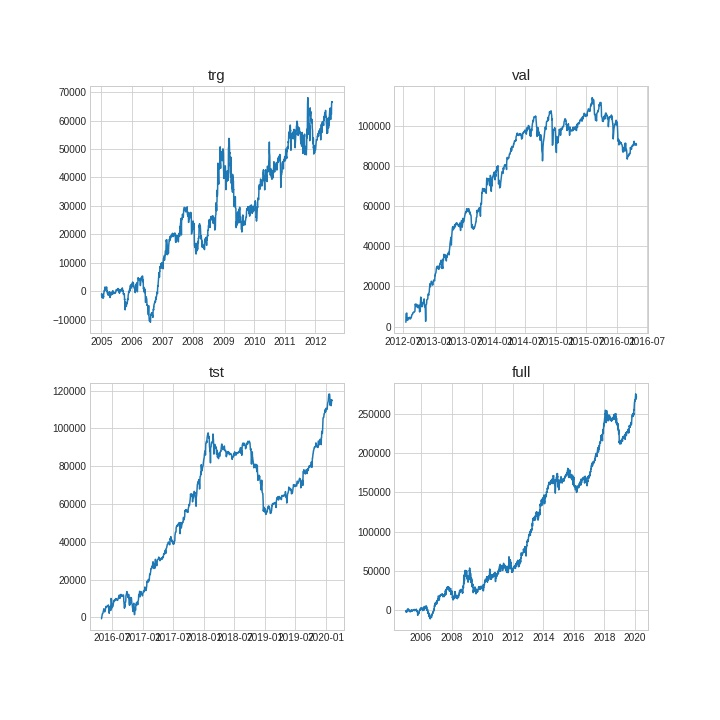

In [18]:
# --- evaluate the untrained model ----
%inline
with mx.timer( 'predicting '):
    Yh = model.to('cpu')( X_da.to_tensor( dtype=dtype, device='cpu' ) )
    model.to( device )
Yh_da = Yh.to_dataarray( da.loc[:,:,hps.responses] )

fig = figure( figsize=(10, 10 ) )
with mx.timer( 'regressing' ):    
    reg = mx.Regression( autocorr=[1, 13, 26] )
    rms = []
    for i, (smp, mask) in pbar( enumerate( [('trg', hps.trg_mask), ('val', hps.val_mask), ('tst',hps.tst_mask), ('full', np.arange( len( Y_da ) ) ) ] ) ):
        # cut out the stuff I added to the datasets for priming
        rm = reg.regress( Yh_da[mask], da.loc[:,:,hps.responses][mask] )    
        ax = subplot( 2,2, i+1 )
        ax.plot( rm.pop('pnl').cumsum() )
        ax.set_title( smp, fontsize=15 )
        hr = rm.pop('hitRate')
        rm['sample'] = smp
        rms.append( rm )
disp( 'Untrained model ', h= 1)
disp( pd.DataFrame( rms ).set_index('sample') )
disp( fig )

In [26]:
# -setup the learner ---
############################
mxtr = mxtr.reload()
mx.Config.start()

disp( mx.tensorboard.start( clear=True ) )
disp( mx.tensorboard.start_server() )

opt_1 = mxtr.FAdam( params=model.parameters(), lr=1e-3, betas=( 0.9, 0.99 ) ) #, tensorboard=False ) # mx.Resolve.halflife( 10)['decay'], mx.Resolve.halflife( 20 )['decay'] ) )
warmup_scheduler = mxtr.callbacks.LRSchedule(
    mxtr.WarmupAdamLR( optimizer=opt_1, min_lr=1e-4, max_lr=1e-3 ) # min_betas=(0.9,0.9), max_betas=(0.9, 0.99), T_max=500 )
)

opt_2 = mxtr.SGD( params=model.parameters(), lr=1e-5, momentum=0.9 )
cycle_scheduler = mxtr.callbacks.LRSchedule(
    mxtr.CycleAdamLR( optimizer=opt_2, min_lr=1e-5, max_lr=1e-3, T_max=200 ) #, min_betas=(0.6,0.8), max_betas=(0.9, 0.9)
)

learner = mxtr.Learner(
    optimizers=opt_1,
    trg_loss=model.trg_loss,
    val_loss=model.val_loss,    
    max_its=5000,
    device=device,
    callbacks=[
        #mxtr.callbacks.LossLogger( patience=1 ),
        mxtr.callbacks.ParameterLogger( named_params=model.named_parameters(), patience=10, grad_autocorr=False ),
        #mxtr.callbacks.ParameterEma( halflife=10, patience=5 ),
        mxtr.callbacks.ParameterMacd( hl_fast=10, hl_slow=100, patience=5, rewind_factor=None  ),
        #mxtr.callbacks.ModelSnapshots( model=model, period=100, on_minimum=True, val_halflife=10 )
        #mxtr.calllbacks.ClipGradients( dropout=0.5, signize=False, clip=None, quantile=None, winlen=100 ),
        warmup_scheduler,
        #mxtr.callbacks.SanityChecker( )
    ]    
)
disp( 'learner hash ', learner.hash(), h=4)
disp( hps )

In [27]:
# --- do the fitting ---
#build up the trianing and validation dataloaders
hps.batch_size = 128
trg_dataloader = mxtr.DataLoader( 
    trg_hankel_dataset, batch_size=None, pin_memory=True, num_workers=12, 
    sampler=mxtr.BatchSampler( sampler=mxtr.RandomSampler( trg_hankel_dataset ), batch_size=hps.batch_size, drop_last=True )
)
val_dataloader = mxtr.DataLoader( 
    val_hankel_dataset, batch_size=None, pin_memory=True , num_workers=12,
    sampler=mxtr.BatchSampler( sampler=mxtr.RandomSampler( val_hankel_dataset ), batch_size=hps.batch_size, drop_last=True  )
    
)
for it in pbar( learner.fit_iterator( data=trg_dataloader, val_data=val_dataloader ) ) :
    continue
#     if it == 100:
#         # switch to sgd
#         learner.optimizers = [opt_2]
#         learner.callbacks.pop(-1)
#         learner.callbacks.append( cycle_scheduler.start() )

#     if it % 100 == 0:
#         tloss = model.val_loss( *[m.to(device) for m in tst_panel_dataset[:]]  )
#         disp( 'testing  loss', tloss, h=4 )
#         disp( learner.profiles.sort_values( 'duration_total', ascending=False ) )

# # run a explicit traning loop
# opt = mxtr.FAdam( params=model.parameters(), lr=1e-3, betas=( 0.9, 0.99 ), tensorboard=False ) # mx.Resolve.halflife( 10)['decay'], mx.Resolve.halflife( 20 )['decay'] ) )
# it  = 0
# for tmb, vmb in pbar( zip( trg_dataloader, val_dataloader ) ):
#     it += 1
#     tmb = [m.to(device) for m in tmb]
#     vmb = [m.to(device) for m in vmb]
#     trg_masker.restrict( tmb[0] )
#     val_masker.restrict( vmb[0] )
#     trg_mask_iterator = trg_masker.mask_iterator('trg')
#     val_mask_iterator = val_masker.mask_iterator('val')
#     opt.zero_grad()
#     trg_mask = next( trg_mask_iterator )
#     val_mask = next( val_mask_iterator )
#     tloss = trg_loss( *tmb, mask=trg_mask )
#     tloss.backward()
#     opt.step()
#     vloss = val_loss( *vmb, mask=val_mask )
#     if it % 10 == 0:
#         tloss = val_loss( *[m.to(device) for m in tst_dataset[:]]  )
#         print( 'testing  loss', tloss )


KeyboardInterrupt: 

In [30]:
learner.callbacks[1].rewind_to_minimum()

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


{'it': 265, 'val_loss_fast': 1.0515831939826608}

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


,n,finite_frac,tilt,pmSR,ic,r2,tstat,DK_10,DK_20,DK_30,DK_40,DK_50,DK_60,DK_70,DK_80,DK_90,ac_1,ac_13,ac_26
sample,,,,,,,,,,,,,,,,,,,
trg,4863142,0.717897,-0.400941,8.553997,0.488313,0.238450,1045.522827,74.739243,68.233634,64.679828,62.140216,60.028849,57.994852,56.073136,54.304631,52.660935,0.976497,0.207103,0.079983
val,2431768,0.994822,0.023221,0.296888,0.009248,0.000086,13.362904,0.788221,0.719364,0.712403,0.710623,0.706464,0.698584,0.693281,0.690646,0.689115,0.972396,0.144649,0.062343
tst,2431768,0.989608,0.057154,-0.015887,-0.001922,0.000004,-0.770151,-0.041385,-0.036805,-0.035242,-0.034426,-0.033904,-0.033660,-0.033560,-0.033622,-0.033756,0.973128,0.143841,0.056018
full,9726284,0.855056,-0.191096,4.958169,0.227216,0.051627,673.066223,30.326161,25.389421,22.750565,20.886794,19.447666,18.268614,17.293267,16.467327,15.752419,0.974946,0.184335,0.078092


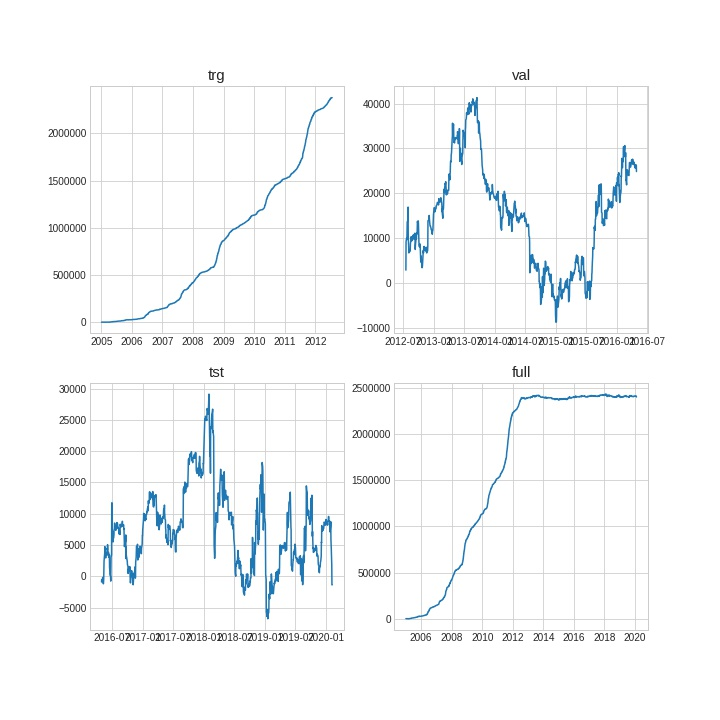

In [31]:
# --- evaluate the Trained model ----
%inline
with mx.timer( 'predicting '):
    Yh = model.to('cpu')( X_da.to_tensor( dtype=dtype, device='cpu' ) )
    model.to( device )
Yh_da = Yh.to_dataarray( da.loc[:,:,hps.responses] )

fig = figure( figsize=(10, 10 ) )
with mx.timer( 'regressing' ):    
    reg = mx.Regression( autocorr=[1, 13, 26] )
    rms = []
    for i, (smp, mask) in pbar( enumerate( [('trg', hps.trg_mask), ('val', hps.val_mask), ('tst',hps.tst_mask), ('full', np.arange( len( Y_da ) ) ) ] ) ):
        # cut out the stuff I added to the datasets for priming
        rm = reg.regress( Yh_da[mask], da.loc[:,:,hps.responses][mask] )    
        ax = subplot( 2,2, i+1 )
        ax.plot( rm.pop('pnl').cumsum() )
        ax.set_title( smp, fontsize=15 )
        hr = rm.pop('hitRate')
        rm['sample'] = smp
        rms.append( rm )
disp( 'Trained model ', h= 1)
disp( pd.DataFrame( rms ).set_index('sample') )
disp( fig )

In [ ]:
X_da.shape

In [ ]:
# plot partial dependency
##############################################
%inline
fig = figure( figsize=(20, 20 ) )
for i in range(X_da.shape[-1]):
    subplot( 4, 4, i+1 )
    plot( X_da[:,:,i].to_series(), Yh_da.to_series() , '.', alpha=0.3 )

In [ ]:
# run a grid of hyperparameters ...
####################################

# hyperparameters
mx.Config.hps = fr.HPSet( 
  
)
mx.Config.code = ''

# configs = []
# for obs_weight in ['no_weight', 'dollar_weight', 'log_weight']:
#     cfg = fr.Config.clone()
#     cfg.hps = cfg.hps.clone( obs_weight=obs_weight )
#     cfg.freeze()
#     display_html( cfg )
#     configs.append( cfg )
# notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../cadre_price_index.20200302 - weight_grid_results.ipynb', n_jobs=None )

configs = []
fr.Config.hps.obs_weight = 'log_weight'
for cbsa_factors in [5, 8, 10]:
    cfg = fr.Config.clone()
    cfg.hps = cfg.hps.clone( cbsa_factors=cbsa_factors )
    cfg.freeze()
    #display_html( cfg )
    configs.append( cfg )
notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../grid_results.ipynb', n_jobs=None )


# fr.Config.hps.obs_weight = 'log_weight'
# fr.Config.hps.cbsa_factors = 8
# configs = []
# for tv in [1, 1e-1, 1e-2, 1e-3]:
#     cfg = fr.Config.clone()
#     cfg.hps = cfg.hps.clone( obs_weight=obs_weight )
#     cfg.freeze()
#     #display_html( cfg )
#     configs.append( cfg )
# notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../cadre_price_index.20200302 - tv_grid_results.ipynb', n_jobs=None )


